## Mackey-Glass equation - 1D example

In [299]:
using CairoMakie
using LinearAlgebra
include("mackeyglassfunc.jl") #system of Mackey-Glass equation
include("mackeytau.jl") #Delay forumla for Mackey-Glass equation
include("f_deriv.jl") #used to find state and/or parameter derivatives
include("jacobian_new.jl") #Jacobian function
include("newton_new.jl") #Newton function
include("F_eq.jl") #Initialisates a function to find equilibria 
include("track_curve_new.jl") #Tracking curve function (used for continuation and equilibria branches)
include("stab_func.jl") #finds stability and eigenvalues (and eigenvector and ω is interested in Hopf bifurcation)

stab_func (generic function with 1 method)

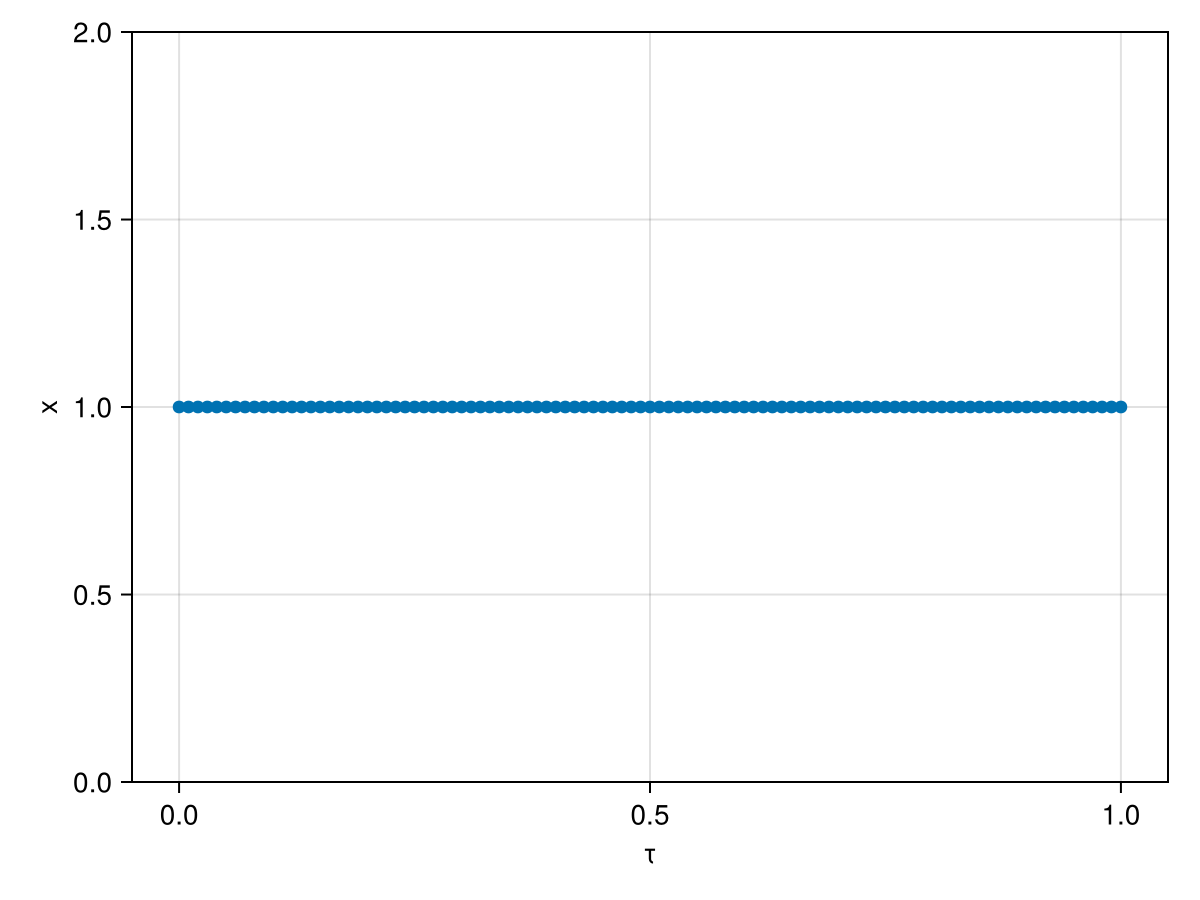

In [314]:
gamma=1.0
#initial states for following parameters (obtained from DDE-Biftool example)
beta=2 #try beta=3 for a change
n=10 #n=3 gives γ/β >=1-2/n so all of x should be stable (By Gupta source)
tau=0
x0=((beta-gamma)/(gamma))^(1/n) #obtained from solving f(x*,...,x*)=0 problem
nd=1 #one delay

y01,feq=F_eq(mackeyglassfunc, x0, [beta,gamma,n,tau],nd, par_indx=4)
ylist1,ytan1=track_curve_new(feq,y01,[0.0,1],stepsize=0.01,nmax=100) 


fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="τ",ylabel="x")
scatter!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
lines!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
#xlims!(ax1,[0,0.6])
fig1

In [315]:
#check that f(x*,...x*,pars)=0
feq(y01)

1-element Vector{Float64}:
 0.0

# Stability

In [316]:
#stability of an equilibrium point
stab_func(mackeyglassfunc,mackeytau, [x0], [0.4],[gamma,beta,n,tau], [4], nd, doprint=1)

(1, ComplexF64[-486.6443159194875 + 0.0im, -486.18302611848276 - 14.786984412209483im, -486.18302611848276 + 14.786984412209483im, -484.8009390965779 - 29.5166099503731im, -484.8009390965779 + 29.5166099503731im, -482.5033950836204 - 44.13173934350201im, -482.5033950836204 + 44.13173934350201im, -479.29927144429337 - 58.575677666874775im, -479.29927144429337 + 58.575677666874775im, -475.2009482429103 - 72.7923913687723im  …  -16.96036821249703 - 63.17032744046449im, -16.96036821249703 + 63.17032744046449im, -12.830555667381196 - 48.573045787450695im, -12.830555667381196 + 48.573045787450695im, -9.371065016542632 - 33.718355653460286im, -9.371065016542632 + 33.718355653460286im, -6.290519408053984 - 18.62524812491093im, -6.290519408053984 + 18.62524812491093im, -1.7833392917704947 - 4.032566044790832im, -1.7833392917704947 + 4.032566044790832im], ComplexF64[0.001330788602784538 + 0.0im 0.001330759488654777 - 4.064149041508388e-5im … -0.0036048896431045392 - 0.06709548624977106im -0.0036

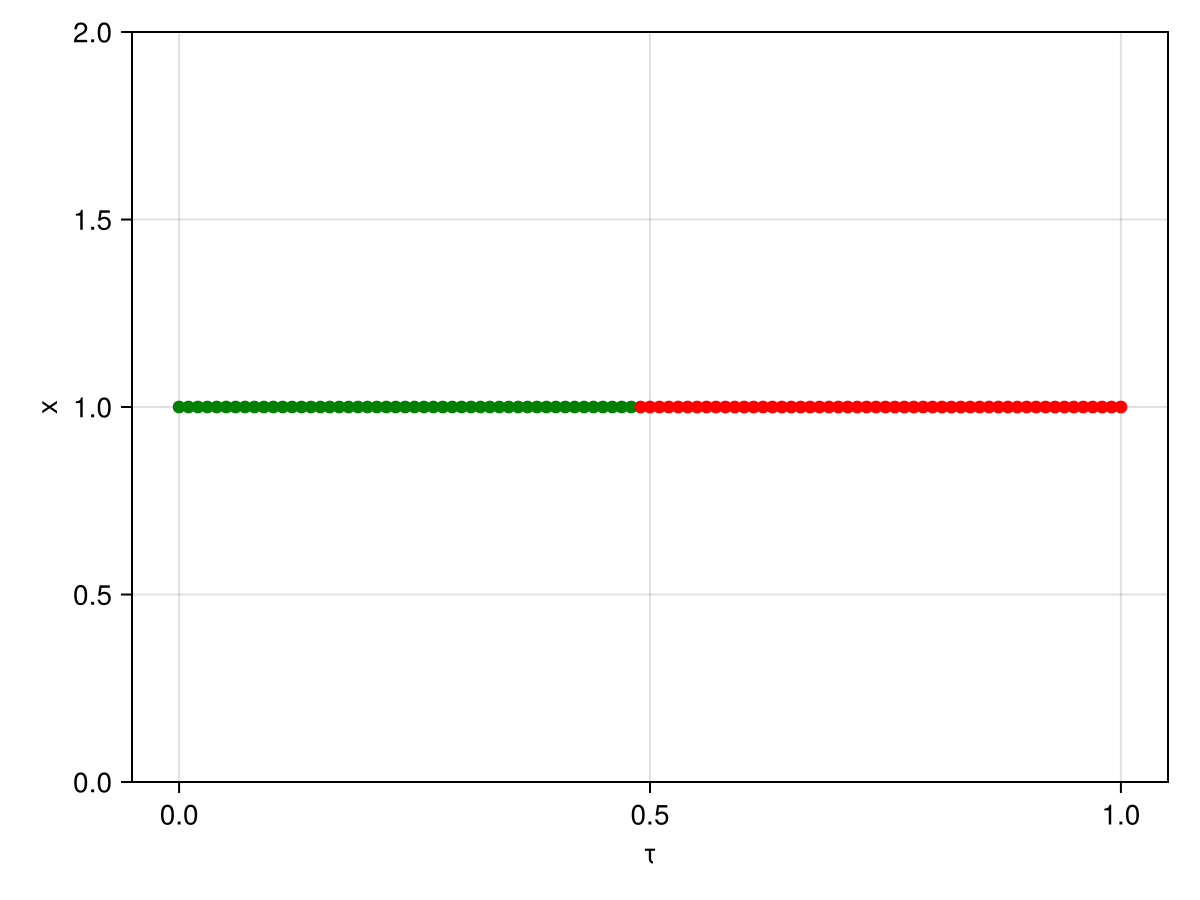

In [317]:
xmat1=hcat([u[1] for u in ylist1])
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)]

plist1=[u[2] for u in ylist1]

m=100 #number of discretised steps
nx=1 #number of states 
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)

for i in 2:neq
    stab[i]=stab_func(mackeyglassfunc,mackeytau,xlist1[i],[plist1[i]],[beta, gamma,n,tau],[4],nd,doprint=0,m=m)[1]
end

stab[1]=1.0 #NOTE THIS IS AN EDUCATED GUESS - NEED TO MAKE MY STABILITY FUNCTION WORK FOR IT!! (currently have m/tau=m/0 in stability function for i=1)
stable=(stab.==1.0)
unstable=(stab.==0.0)

fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="τ",ylabel="x")
scatter!(ax2,plist1[stable],[u[1] for u in xlist1[stable]], color="green")
scatter!(ax2,plist1[unstable],[u[1] for u in xlist1[unstable]], color="red")
#xlims!(ax2,[0,0.6])
fig2


# Hopf Bifurcation

In [318]:
hopf_indx=findfirst(isequal(0.0), stab)
p_hopf_est=plist1[hopf_indx]

0.49000000000000027

In [321]:
include("create_hopffunc.jl")
yh01,fhopf=create_hopffunc(mackeyglassfunc,mackeytau,[beta,gamma,n,tau],xlist1[hopf_indx],[plist1[hopf_indx]],[4],nd)
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=newton_new(fhopf,yh01) 
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
tau_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1]
println("The τ value for hopf bifurcation: $tau_hopf")
println("The ω value for hopf bifurcation: $om_hopf")

The initial guess for Hopf info: [1.0, 1.0, 0.0, 3.7503875281389147, 0.49000000000000027]
The true information for the Hopf bifurcation: [1.0, 1.0, 0.0, 3.87298334183115, 0.47081962953876083]
converged?: true
The τ value for hopf bifurcation: 0.47081962953876083
The ω value for hopf bifurcation: 3.87298334183115


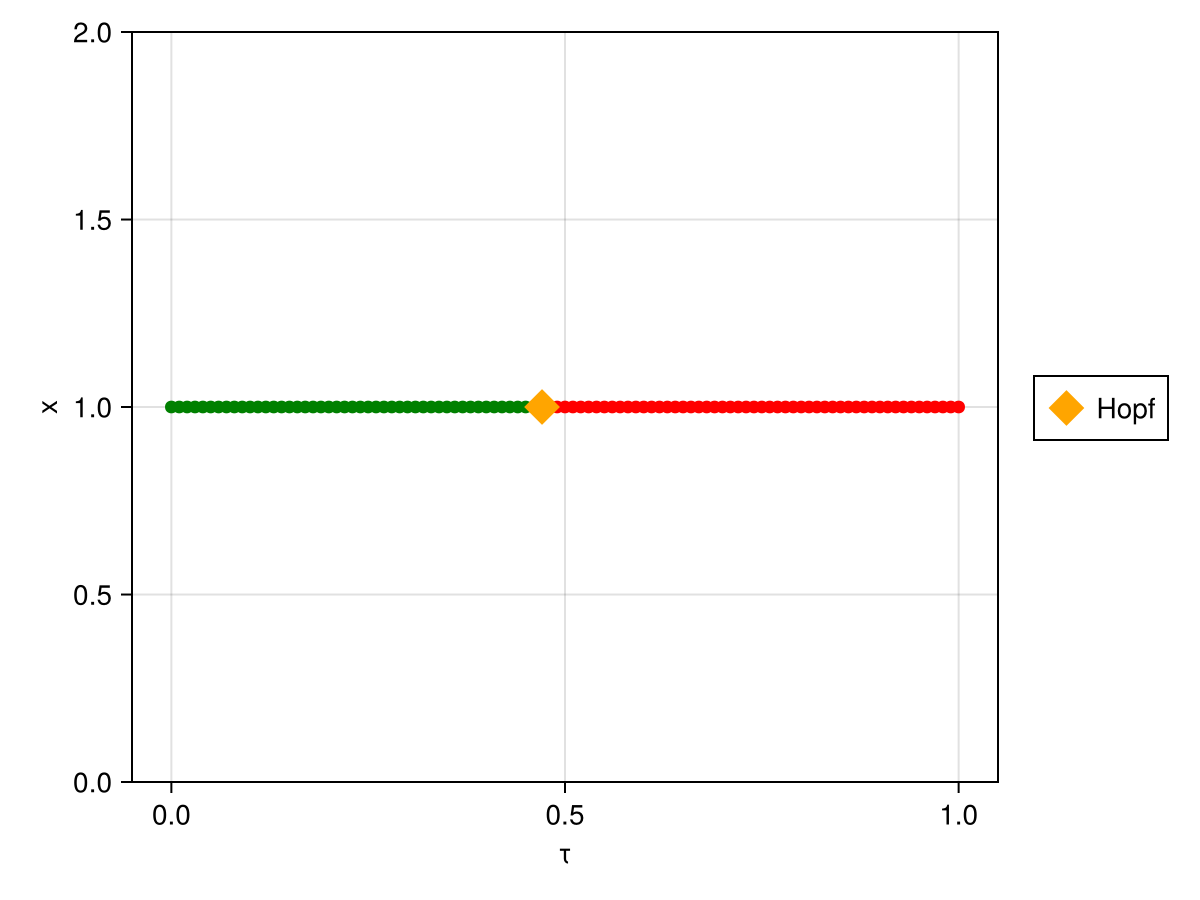

In [337]:
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="τ",ylabel="x")
scatter!(ax2,plist1[stable],[u[1] for u in xlist1[stable]], color="green")
scatter!(ax2,plist1[unstable],[u[1] for u in xlist1[unstable]], color="red")
scatter!(ax2,tau_hopf,x_hopf,marker=:diamond,color=:orange,markersize=:20, label="Hopf")
Legend(fig2[1,2],ax2,merge=true)
fig2

# Continuation in (tau,beta)-plane

Has not converged


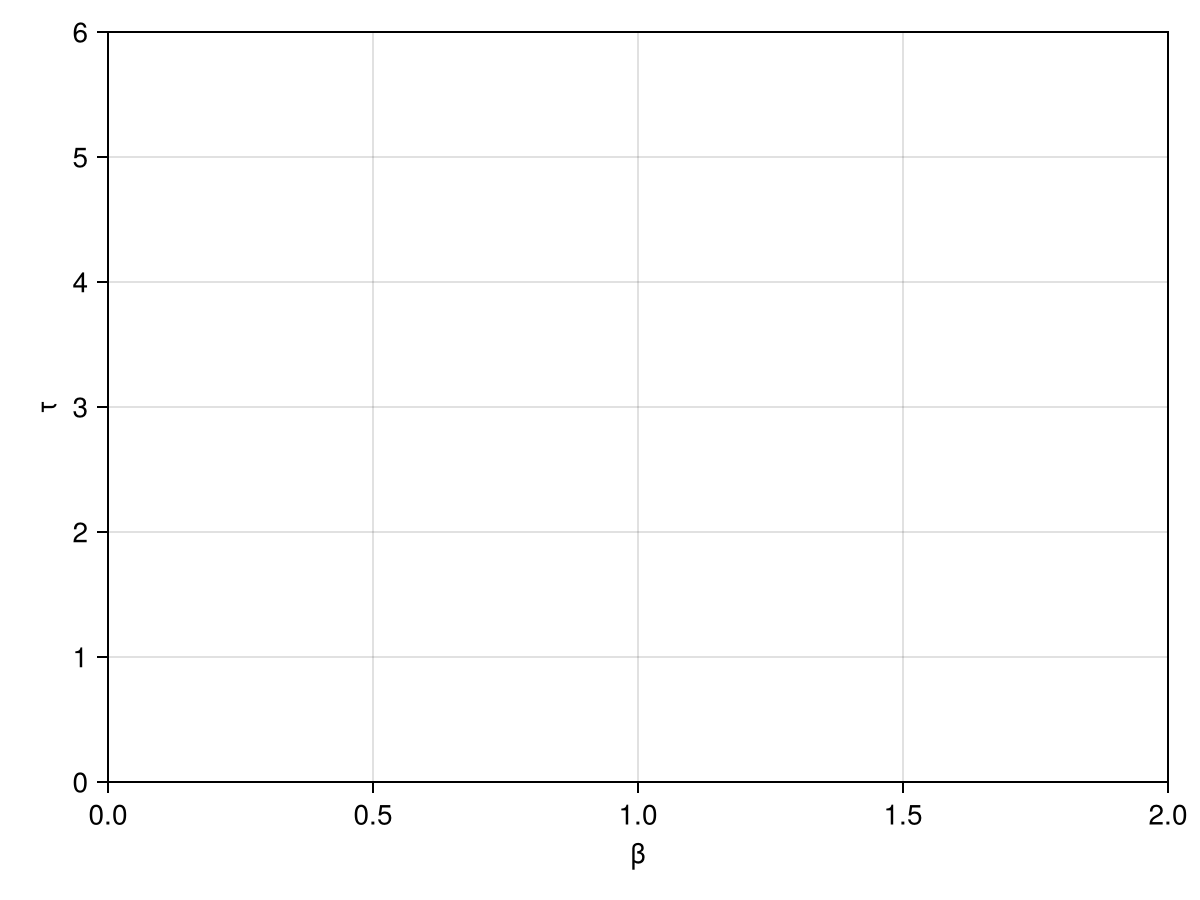

In [352]:
yheq01,fhopfeq1=create_hopffunc(mackeyglassfunc,mackeytau,[0,gamma,n,tau_hopf],[x_hopf],[0,tau_hopf],[1,4],nd)
#yheq01,fhopfeq1=create_hopffunc(mackeyglassfunc,mackeytau,[0,gamma,n,tau_hopf],[x_hopf],[tau_hopf,0],[4,1],nd)
yheqlist1,heqtan1=track_curve_new(fhopfeq1,yheq01,[0.0,0,0,0,1,1],nmax=2000)

#Below marks the Hopf bifurcation for fixed beta=2
#a_vals=[u[end-1] for u in yheqlist1]
#b_vals=[u[end] for u in yheqlist1]
#b1_5indx=argmin(abs.([u[end] for u in yheqlist1].-beta))

#a1=a_vals[b1_5indx]
#b1=b_vals[b1_5indx]

#Plot of continuation/tracking in (a,b) plane
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="β",ylabel="τ")
scatter!(ax4,[u[end-1] for u in yheqlist1[2:end]],[u[end] for u in yheqlist1[2:end]],color="green",markersize=:7)
#hlines!(ax4,beta,linestyle=:dash)
#scatter!(ax4,a1,b1,marker=:diamond,color=:black)
#vlines!(ax4,beta,linestyle=:solid, linewidth=:5,color=:red)
ylims!(ax4,[0,6])
fig4

In [353]:
yheq01

6-element Vector{Float64}:
  1.0
  1.0
 -0.0
  0.0
  0.0
  0.47081962953876083